In [2]:
from mpi4py import MPI
import numpy as np
import dxchange
import torch as tc
import os
import torch as tc
import torch.nn.functional as F
from tqdm import tqdm
import csv

import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rcParams['pdf.fonttype'] = 'truetype'
fontProperties = {'family': 'serif', 'serif': ['Helvetica'], 'weight': 'normal', 'size': 12}
plt.rc('font', **fontProperties)

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as mtick

In [3]:
## For a 64 x 64 x 64 sample: sample8 ##
######################################################################
dev = 'cpu'
# experiemtal parameters #
theta_st = tc.tensor(0).to(dev)
theta_end = tc.tensor(2 * np.pi).to(dev)
n_theta =  tc.tensor(200).to(dev)
theta_ls = - tc.linspace(theta_st, theta_end, n_theta+1)[:-1].to(dev)
sample_size_n = tc.tensor(64).to(dev)
sample_height_n = tc.tensor(64).to(dev)
sample_size_cm = tc.tensor(0.01).to(dev)
this_aN_dic = {"Ca": 20, "Sc": 21}, 
probe_energy = np.array([20.0])
probe_cts = tc.tensor(1.0E7).to(dev)
det_size_cm = 0.24
det_from_sample_cm = 1.6
det_ds_spacing_cm = 0.1

# path of true grid concentration of the sample #
grid_path = './data/sample8_size_64_pad/nElements_2'
f_grid = 'grid_concentration.npy'

# XRF and XRT data path #
data_path = './data/sample8_size_64_data/nElements_2'
f_XRF_data = 'XRF_sample8'
f_XRT_data = 'XRT_sample8'

# path of storing the intersecting information and the reconstructing results #
recon_path = 'data/sample8_size_64_recon/limited_solid_angle/Noise/detSpacing_0.4_dpts_5/b_1.56E-5/nElements_2_selfAb_nEpochs_40_nThetas_200/'
P_save_path = os.path.join(recon_path, 'Intersecting_Length_64_64_64')
f_recon_parameters = 'recon_parameters.txt'
f_recon_grid = 'grid_concentration'
f_initial_guess = 'initialized_grid_concentration'
######################################################################

In [4]:
def rotate(arr, theta, dev):
    """
    This function rotates the grid concentration with dimension: (n_element, sample_height_n, sample_size_n, sample_size_n)
    The rotational axis is along dim 1 of the grid
    
    Parameters
    ----------
    arr : torch tensor
        grid concentration
        
    theta : float
        rotation angle in radians (clockwise)
    
    dev : string
        specify "cpu" or the cuda diveice (ex: cuda:0)


    Returns
    -------
    q : torch tensor
        the rotated grid concentration

    """
    
    m0 = tc.tensor([tc.cos(theta), -tc.sin(theta), 0.0], device=dev)
    m1 = tc.tensor([tc.sin(theta), tc.cos(theta), 0.0], device=dev)
    m = tc.stack([m0, m1]).view(1, 2, 3)
    m = m.repeat([arr.shape[0], 1, 1])
    
    g = F.affine_grid(m, arr.shape)
    q = F.grid_sample(arr, g, padding_mode='border')
    
    return q

## Plot the ground truth

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


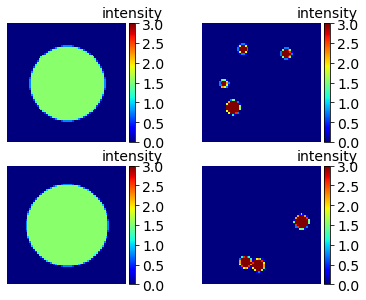

In [5]:
# layer_idx_ls = range(0,5,1)
layer_idx_ls = [30, 40]


gt = np.load(os.path.join(grid_path, f_grid))

image_size = gt.shape[-1]
fig6 = plt.figure(figsize=(4 * gt.shape[0] * 0.8 , 3 * len(layer_idx_ls) * 0.8))
gs6 = gridspec.GridSpec(nrows= len(layer_idx_ls), ncols = gt.shape[0], width_ratios=[1] * gt.shape[0])


for element_idx in range(gt.shape[0]):
    for idx, layer_idx in enumerate(layer_idx_ls):
        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
        pos = fig6_ax1.imshow(gt[element_idx,layer_idx], cmap='jet', vmin=0, vmax=3.0, extent=[0, image_size, image_size, 0], origin='upper')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.arange(0,3.5,0.5)
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=14) 
        cbar.ax.set_title('intensity', size='14')

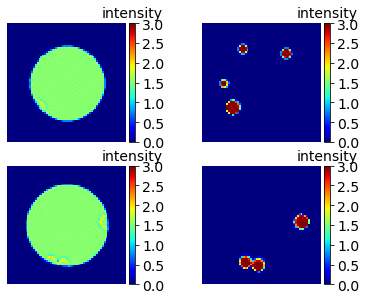

In [6]:
recon = np.load(os.path.join(recon_path, f_recon_grid + '.npy'))

image_size = recon.shape[-1]
fig6 = plt.figure(figsize=(4 * recon.shape[0] * 0.8 , 3 * len(layer_idx_ls) * 0.8))
gs6 = gridspec.GridSpec(nrows= len(layer_idx_ls), ncols = recon.shape[0], width_ratios=[1] * recon.shape[0])


for element_idx in range(recon.shape[0]):
    for idx, layer_idx in enumerate(layer_idx_ls):
        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
        pos = fig6_ax1.imshow(recon[element_idx,layer_idx], cmap='jet', vmin=0, vmax=3.0, extent=[0, image_size, image_size, 0], origin='upper')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.arange(0,3.5,0.5)
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=14) 
        cbar.ax.set_title('intensity', size='14')

data/sample1_recon/initialized_grid_concentration.npy


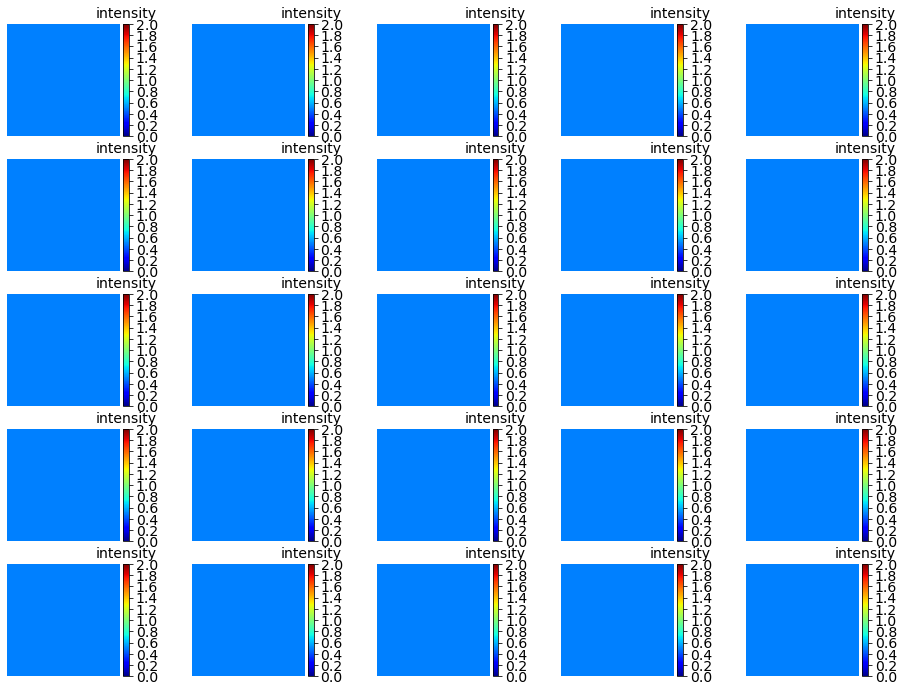

In [5]:
recon_ini = np.load(os.path.join(recon_path, f_initial_guess)+'.npy')
print(os.path.join(recon_path, f_initial_guess)+'.npy')
image_size = recon_ini.shape[-1]
fig6 = plt.figure(figsize=(4 * recon_ini.shape[0] * 0.8 , 3 * len(layer_idx_ls) * 0.8))
gs6 = gridspec.GridSpec(nrows= len(layer_idx_ls), ncols = recon_ini.shape[0], width_ratios=[1] * recon_ini.shape[0])


for element_idx in range(recon_ini.shape[0]):
    for idx, layer_idx in enumerate(layer_idx_ls):
        fig6_ax1 = fig6.add_subplot(gs6[idx, element_idx])
        fig6_ax1.set_xticks(np.arange(0, image_size, 1))
        fig6_ax1.set_yticks(np.arange(0, image_size, 1))
        # fig6_ax1.grid(color='w', linewidth=2)
        fig6_ax1.axis('off')
        pos = fig6_ax1.imshow(recon_ini[element_idx,layer_idx], cmap='jet', vmin=0, vmax=2.0, extent=[0, 5, 5, 0], origin='upper')
        divider = make_axes_locatable(fig6_ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        ticks = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
        cbar = fig6.colorbar(pos, cax=cax, ticks=ticks)
        cbar.ax.tick_params(labelsize=14) 
        cbar.ax.set_title('intensity', size='14')